In [20]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.utils.data import download_file
import torch

# CLEAN

In [2]:
dirname = "/home/mjybarth/projects/rrg-lplevass/data/misha_dsharp_data/"
fname = dirname + "HD143006_continuum.fits"
hdul = fits.open(fname)
hdu = hdul[0]
clean_img = np.squeeze(hdu.data)
header = hdu.header
hdul.close()

In [3]:
# get the number of pixels in each direction
nx = header["NAXIS1"]
ny = header["NAXIS2"]
# RA coordinates
CDELT1 = 3600 * header["CDELT1"]  # Convert from units of degrees to arcsec

# DEC coordinates
CDELT2 = 3600 * header["CDELT2"]  # [arcsec]

# calculate the RA and DEC pixel centers
RA = (np.arange(nx) - nx / 2) * CDELT1  # [arcsec]
DEC = (np.arange(ny) - ny / 2) * CDELT2  # [arcsec]

# matplotlib imshow extent needs to include extra half-pixels.
ext = (
    RA[0] - CDELT1 / 2,
    RA[-1] + CDELT1 / 2,
    DEC[0] - CDELT2 / 2,
    DEC[-1] + CDELT2 / 2,
)  # [arcsec]

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

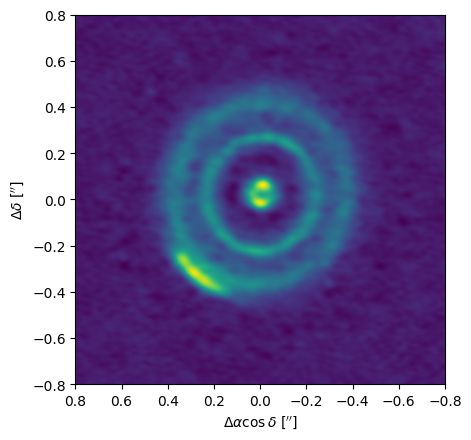

In [4]:
plt.imshow(clean_img, origin="lower", extent=ext)
# zooming in a little to focus on the disk
r = 0.8
plt.xlim(left=r, right=-r)
plt.ylim(top=r, bottom=-r)
# axis labels
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

# MPoL

In [5]:
# load extracted visibilities from npz file
fname = dirname + "HD143006_continuum.npz"
d = np.load(fname)
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data = d["data"]

In [16]:
from mpol import gridding, coordinates

# we'll assume the same cell_size as before
cell_size = 0.003  # arcseconds

# create DirtyImager object
coords = coordinates.GridCoords(cell_size=cell_size, npix=512)
imager = gridding.DirtyImager(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data.real,
    data_im=data.imag,
)

Text(0.5, 1.0, 'Baselines')

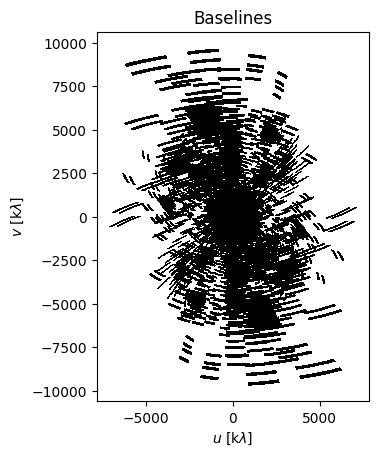

In [6]:
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=0.5, rasterized=True, linewidths=0.0, c="k")
ax.scatter(-uu, -vv, s=0.5, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
ax.set_aspect("equal")
ax.set_title("Baselines")

In [7]:
cell_size = np.abs(header["CDELT1"] * 3600)  # [arcsec]
print("cell_size is {:.4f} arcseconds".format(cell_size))

cell_size is 0.0030 arcseconds


In [8]:
from mpol import gridding

imager = gridding.DirtyImager.from_image_properties(
    cell_size=cell_size,
    npix=512,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data.real,  # separating the real and imaginary values of our data
    data_im=data.imag,
)

In [9]:
def image_and_plot(weighting, robust=None):

    img, beam = imager.get_dirty_image(
        weighting=weighting, robust=robust, unit="Jy/arcsec^2"
    )

    kw = {"origin": "lower", "extent": imager.coords.img_ext}
    fig, ax = plt.subplots(ncols=1)
    im = ax.imshow(np.squeeze(img), **kw)
    cbar = plt.colorbar(im)
    cbar.set_label(r"$\mathrm{Jy}/\mathrm{arcsec}^2$")

    title = weighting
    if robust is not None:
        title += " r={:.1f}".format(robust)
    ax.set_title(title)
    ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
    ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
    r = 0.7
    plt.xlim(left=r, right=-r)
    plt.ylim(bottom=-r, top=r)

    return np.squeeze(img)

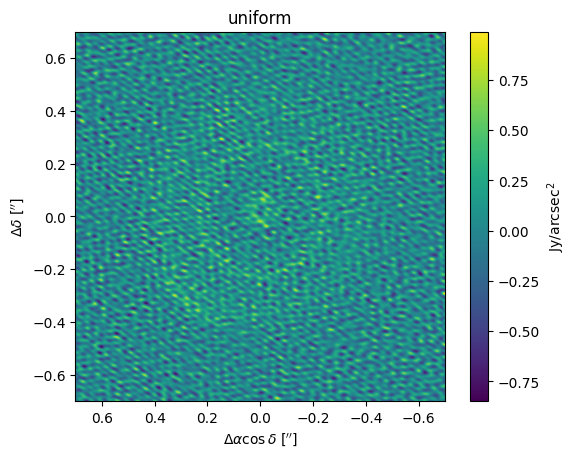

In [10]:
_ = image_and_plot(weighting="uniform")

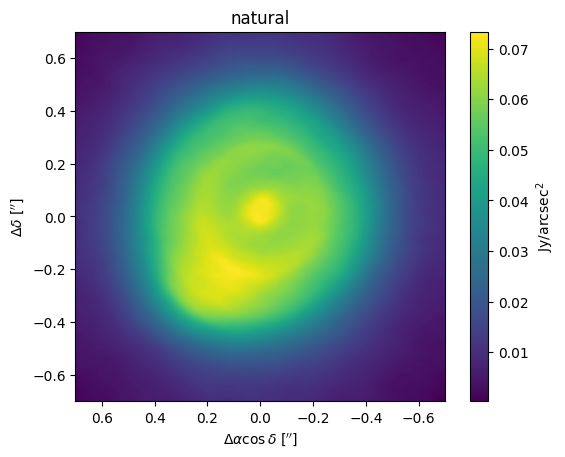

In [11]:
_ = image_and_plot(weighting="natural")

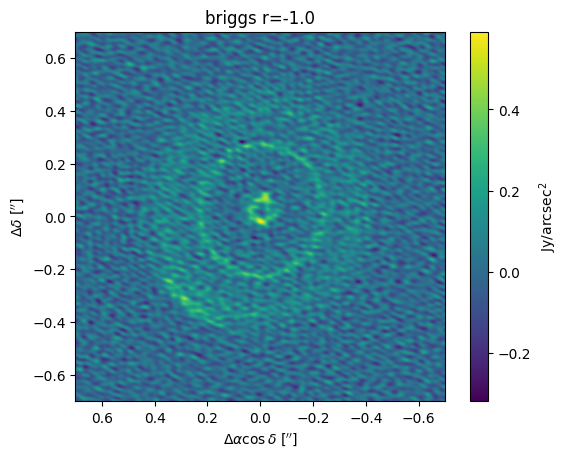

In [12]:
_ = image_and_plot(weighting="briggs", robust=-1.0)

In [13]:
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0, unit="Jy/arcsec^2")

In [17]:
averager = gridding.DataAverager(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data.real,
    data_im=data.imag,
)
dataset = (
    averager.to_pytorch_dataset()
) 

In [18]:
from mpol.precomposed import SimpleNet

model = SimpleNet(coords=coords, nchan=averager.nchan)

In [21]:
# convert the dirty image into a tensor
dirty_image = torch.tensor(img.copy())

# initialize an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)
loss_fn = torch.nn.MSELoss()  # creating the MSEloss function from Pytorch

In [22]:
for iteration in range(500):

    optimizer.zero_grad()

    model()  # get the predicted model
    sky_cube = model.icube.sky_cube

    loss = loss_fn(sky_cube, dirty_image)  # calculate the loss

    loss.backward()  # calculate gradients of parameters
    optimizer.step()  # update the parameters

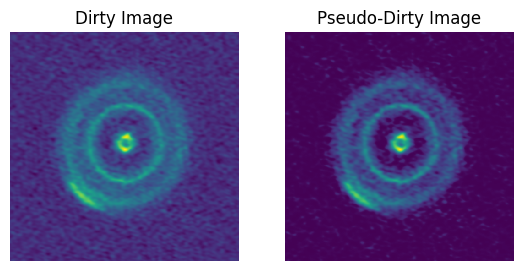

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(6.5, 4))

ax[0].imshow(
    np.squeeze(dirty_image.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)

ax[1].imshow(
    np.squeeze(model.icube.sky_cube.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)

r = 0.75
for a in ax:
    a.set_xlim(left=0.75, right=-0.75)
    a.set_ylim(bottom=-0.75, top=0.75)
    a.axis("off")

ax[0].set_title("Dirty Image")
_ = ax[1].set_title("Pseudo-Dirty Image")

In [24]:
torch.save(model.state_dict(), "model.pt")

In [25]:
from torch.utils.tensorboard import SummaryWriter
import os

logs_base_dir = "./logs/"
writer = SummaryWriter(logs_base_dir)
os.makedirs(logs_base_dir, exist_ok=True)
%load_ext tensorboard

ModuleNotFoundError: No module named 'tensorboard'

In [26]:
def log_figure(model):
    """
    Args:
        model: the SimpleNet model instance

    Returns:
        matplotlib figure with plots corresponding to image
        plane model cube.
    """

    fig, ax = plt.subplots(ncols=1, nrows=1)
    im = ax.imshow(
        np.squeeze(model.icube.sky_cube.detach().cpu().numpy()),
        origin="lower",
        interpolation="none",
        extent=model.icube.coords.img_ext,
    )
    plt.colorbar(im, ax=ax)

    return fig

In [27]:
from mpol import losses


def train(model, dataset, optimizer, config, writer=None, logevery=50):
    model.train()
    for iteration in range(config["epochs"]):
        optimizer.zero_grad()
        vis = model()  # calculate the predicted model
        sky_cube = model.icube.sky_cube

        loss = (
            losses.nll_gridded(vis, dataset)
            + config["lambda_sparsity"] * losses.sparsity(sky_cube)
            + config["lambda_TV"] * losses.TV_image(sky_cube)
            + config["entropy"] * losses.entropy(sky_cube, config["prior_intensity"])
            + config["TSV"] * losses.TSV(sky_cube)
        )

        if (
            iteration % logevery == 0
        ) and writer is not None:  # logging the loss and image for visualization and analysis
            writer.add_scalar("loss", loss.item(), iteration)
            writer.add_figure("image", log_figure(model), iteration)

        loss.backward()  # calculate gradient of the parameters
        optimizer.step()  # update the model parameters

    return loss.item()

In [28]:
model.load_state_dict(
    torch.load("model.pt")
)  # load our initialized model from the previous section

<All keys matched successfully>

In [29]:
config = (
    {  # config includes the hyperparameters used in the function and in the optimizer
        "lr": 0.3,
        "lambda_sparsity": 7.0e-05,
        "lambda_TV": 0.00,
        "entropy": 1e-03,
        "prior_intensity": 1.5e-07,
        "TSV": 0.00,
        "epochs": 1000,
    }
)

In [42]:
config = (
    {  # config includes the hyperparameters used in the function and in the optimizer
        "lr": 0.3,
        'lambda_sparsity': 1.8e-4,
        'lambda_TV': 2.3e-5,
        'entropy': 7.4e-06,
        'prior_intensity': 5.0e-07,
        'TSV': 1.0e-02,
        "epochs": 1000,
    }
)

In [43]:
optimizer = torch.optim.Adam(
    model.parameters(), lr=config["lr"]
)  # create our optimizer, using the learning rate from config

In [44]:
train(model, dataset, optimizer, config, writer=None)

2.4634416001686286

In [33]:
def test(model, dataset):
    model.eval()
    vis = model()
    loss = losses.nll_gridded(
        vis, dataset
    )  # calculates the loss function that goes to make up the cross validation score
    return loss.item()

In [34]:
def cross_validate(model, config, k_fold_datasets, MODEL_PATH, writer=None):
    test_scores = []

    for k_fold, (train_dset, test_dset) in enumerate(k_fold_datasets):

        # reset model
        model.load_state_dict(torch.load(MODEL_PATH))

        # create a new optimizer for this k_fold
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

        # train for a while
        train(model, train_dset, optimizer, config, writer=writer)
        # evaluate the test metric
        test_scores.append(test(model, test_dset))

    # aggregate all test scores and sum to evaluate cross val metric
    test_score = np.sum(np.array(test_scores))

    # adds cross validation score
    if writer is not None:
        writer.add_scalar("Cross Validation", test_score)

    return test_score

In [35]:
from mpol import crossval, datasets

# create a radial and azimuthal partition for the dataset
dartboard = datasets.Dartboard(coords=coords)

# create cross validator using this "dartboard"
k = 5
cv = crossval.DartboardSplitGridded(dataset, k, dartboard=dartboard, seed=42)

# ``cv`` is a Python iterator, it will return a ``(train, test)`` pair of ``GriddedDataset``s for each iteration.
# Because we'll want to revisit the individual datasets
# several times in this tutorial, we're storing them into a list

k_fold_datasets = [(train, test) for (train, test) in cv]

In [36]:
MODEL_PATH = "model.pt"

new_config = (
    {  # config includes the hyperparameters used in the function and in the optimizer
        "lr": 0.3,
        "lambda_sparsity": 7.0e-05,
        "lambda_TV": 0.00,
        "entropy": 1e-03,
        "prior_intensity": 1.5e-07,
        "TSV": 0.00,
        "epochs": 1000,
    }
)

In [39]:
# new directory to write the progress of our first cross val. loop to
#cv_log_dir1 = logs_base_dir + "cv/cv1/"
#cv_writer1 = SummaryWriter(cv_log_dir1)
#os.makedirs(cv_log_dir1, exist_ok=True)

cv_score1 = cross_validate(
    model, new_config, k_fold_datasets, MODEL_PATH, writer=None
)
print(f"Cross Validation Score: {cv_score1}")

KeyboardInterrupt: 

In [ ]:
# new directory to write the progress of our second cross val. loop to
#cv_log_dir2 = logs_base_dir + "cv/cv2/"
#cv_writer2 = SummaryWriter(cv_log_dir2)
#os.makedirs(cv_log_dir2, exist_ok=True)

new_config = (
    {  # config includes the hyperparameters used in the function and in the optimizer
        "lr": 0.3,
        "lambda_sparsity": 1.0e-4,
        "lambda_TV": 1.0e-4,
        "entropy": 1e-02,
        "prior_intensity": 2.0e-09,
        "TSV": 1.0e-6,
        "epochs": 850,
    }
)
cv_score2 = cross_validate(
    model, new_config, k_fold_datasets, MODEL_PATH, writer=None
)
print(f"Cross Validation Score: {cv_score2}")

In [ ]:
# new directory to write the progress of our third cross val. loop to
#cv_log_dir3 = logs_base_dir + "cv/cv3/"
#cv_writer3 = SummaryWriter(cv_log_dir3)
#os.makedirs(cv_log_dir3, exist_ok=True)

new_config = (
    {  # config includes the hyperparameters used in the function and in the optimizer
        "lr": 0.3,
        'lambda_sparsity': 1.8e-4,
        'lambda_TV': 2.3e-5,
        'entropy': 7.4e-06,
        'prior_intensity': 5.0e-07,
        'TSV': 1.0e-02,
        "epochs": 1000,
    }
)

cv_score3 = cross_validate(
    model, new_config, k_fold_datasets, MODEL_PATH, writer=None
)
print(f"Cross Validation Score: {cv_score3}")

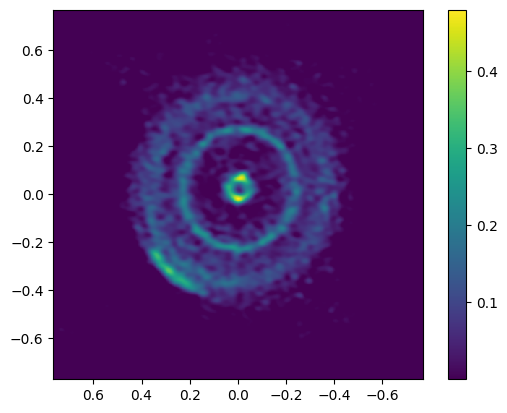

In [46]:
fig, ax = plt.subplots()
im = ax.imshow(
    np.squeeze(model.icube.sky_cube.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)
plt.colorbar(im)